TODOS:
1. Optimize Code to use hardware acceleration.
2. Numerically invert the map.

In [2]:
# === General Imports ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.func import vmap, hessian
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import gc
import warnings
import copy
from typing import Optional, Iterable

# === JAX Imports ===
import jax
import jax.numpy as jnp
from jax import grad
from functools import partial
from scipy.special import erf, gamma
from scipy.linalg import eigvals

# --- Hardware Acceleration Setup ---

# 1. PyTorch Device Selection (for ICNN Flow)
if torch.cuda.is_available():
    optimal_device = "cuda"  # Nvidia GPUs
elif torch.backends.mps.is_available():
    optimal_device = "mps"  # Apple Silicon
else:
    optimal_device = "cpu"
device = torch.device(optimal_device)
print(f"Using device: {device}")

# 2. JAX Configuration (for RBF Flow)
# Enable 64-bit precision for JAX for numerical stability
jax.config.update("jax_enable_x64", True)
# JAX will automatically use GPU/TPU if available.

Using device: mps


## Part 1: Input Convex Neural Network (ICNN) Flow

This section implements a normalizing flow based on a deep Input Convex Neural Network (ICNN). The `DeepConvexFlow` class creates a potential function $\Phi(x) = \sum_i \beta_i \Phi_i(x) + \frac{1}{2} w_0 \|x\|^2$, where each $\Phi_i$ is an ICNN. The transport map is then $f(x) = \nabla \Phi(x)$.


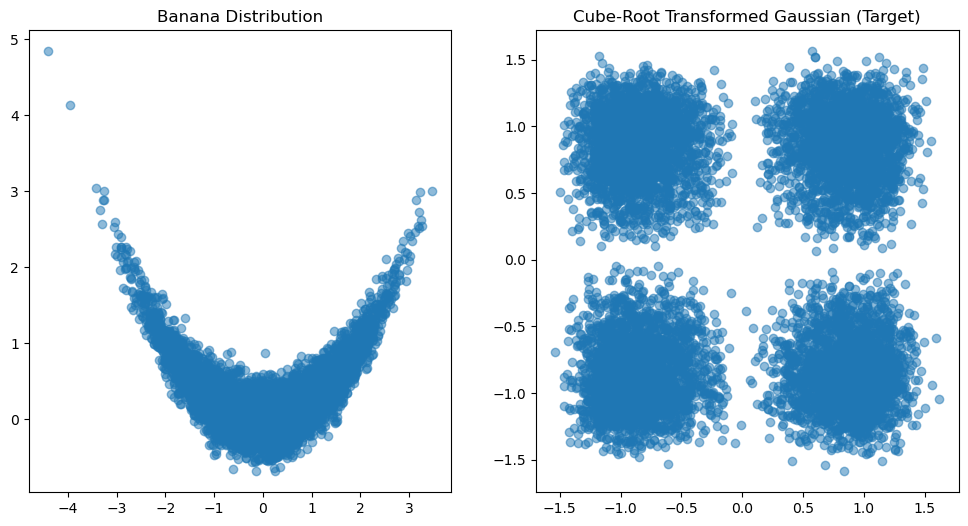

Saved icnn_data_distributions.png


In [4]:
def sample_banana(n_samples=5000, sigma=1.0, noise=0.2):
    """Generates samples from a 2D 'banana' distribution."""
    u = np.random.normal(0, sigma, size=n_samples)
    x1 = u
    x2 = (u**2)/4 + np.random.normal(0, noise, size=n_samples)
    return np.stack([x1, x2], axis=1)

def T(xy):
    """Cube-root transformation for target distribution."""
    x = xy[:, 0]
    y = xy[:, 1]
    return np.stack([np.cbrt(x), np.cbrt(y)], axis=1)


# Sample data from the cube-root transformed Gaussian (Target Distribution for ICNN)
base_dist = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
S_base = base_dist.sample((10000,)).cpu().numpy()
X_target_icnn = T(S_base)
np.savez('./X_data_icnn.npz', X=X_target_icnn)

# Sample data from the banana distribution
X_banana = sample_banana(10000)

# Plot the two distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(X_banana[:, 0], X_banana[:, 1], alpha=0.5)
ax1.set_title('Banana Distribution')
ax2.scatter(X_target_icnn[:, 0], X_target_icnn[:, 1], alpha=0.5)
ax2.set_title('Cube-Root Transformed Gaussian (Target)')
plt.savefig("icnn_data_distributions.png")
plt.show()
print("Saved icnn_data_distributions.png")

In [5]:
class ICNN(nn.Module):
    """
    Input Convex Neural Network (ICNN).
    
    This network is constrained such that its output is a convex function of its
    input 'x'. This is achieved by ensuring all weights associated with the
    non-linear activation paths (Wz_layers) are non-negative.
    """
    
    def __init__(self, n_dim, hidden_dims):
        """
        Initializes the ICNN.
        
        Args:
            n_dim (int): Dimensionality of the input space (e.g., 2 for 2D data).
            hidden_dims (list of int): A list specifying the size of each hidden layer.
        """
        super(ICNN, self).__init__()
        self.n_dim = n_dim
        self.hidden_dims = hidden_dims

        self.Wx_layers = nn.ModuleList()  # Layers for direct input 'x'
        self.Wz_layers = nn.ModuleList()  # Layers for activated path 'z'
        self.b = nn.ParameterList()       # Bias parameters

        prev_dim = 0
        for idx, hidden_dim in enumerate(hidden_dims):
            # Linear layer for the input x -> z_i
            wx = nn.Linear(n_dim, hidden_dim, bias=False)
            
            # Linear layer for the previous activation z_{i-1} -> z_i
            # Note: bias is added manually via self.b
            wz = nn.Linear(prev_dim, hidden_dim, bias=False)

            if idx == 0:
                # For the first layer, there is no previous 'z', so we zero its weights
                # to effectively make z_1 = softplus(Wx_1(x) + b_1)
                with torch.no_grad():
                    wz.weight.zero_()

            self.Wx_layers.append(wx)
            self.Wz_layers.append(wz)
            self.b.append(nn.Parameter(torch.zeros(hidden_dim)))

            prev_dim = hidden_dim
            
        # Final output layer. Must also have non-negative weights for convexity.
        self.output_layer = nn.Linear(hidden_dims[-1], 1, bias=False)

    def forward(self, x):
        """
        Forward pass of the ICNN.
        z_i = softplus(Wx_i(x) + Wz_i(z_{i-1}) + b_i)
        """
        z = None
        for i in range(len(self.hidden_dims)):
            wx_x = self.Wx_layers[i](x)

            if i == 0:
                linear_sum = wx_x + self.b[i]
            else:
                wz_z = self.Wz_layers[i](z)
                linear_sum = wx_x + wz_z + self.b[i]
            
            # Softplus activation ensures non-linearity while maintaining convexity path
            z = F.softplus(linear_sum)

        output = self.output_layer(z)
        return output

    def enforce_constraints(self):
        """
        Enforces the non-negativity constraint on Wz weights and the output layer.
        This must be called after each optimizer.step() during training to
        project the weights back onto the convex set.
        """
        with torch.no_grad():
            # Start from i=1 because Wz_0 is forced to be zero
            for i in range(1, len(self.Wz_layers)):
                # Clamp weights to be non-negative
                self.Wz_layers[i].weight.clamp_(min=0)
            
            # Ensure output layer weights are also non-negative
            self.output_layer.weight.clamp_(min=0)

In [6]:
class DeepConvexFlow(nn.Module):
    """
    Deep convex potential flow, parameterized by a sum of ICNNs and a
    quadratic regularization term.
    
    Potential Function:
    Phi(x) = sum_{i=1}^{n} softplus(beta_i) * ICNN_i(x) + w0 * ||x||^2 / 2
    
    Transport Map:
    f(x) = grad_x Phi(x)
    """

    def __init__(
        self,
        icnn: nn.Module,          # A base ICNN model to be deep-copied
        dim: int,
        n_icnns: int = 3,          # Number of ICNNs to sum
        atol: float = 1e-3,        # Jitter for stable log-determinant
        bias_w1: float = 0.0,      # Initial bias for beta weights
        w0_scale: float = 0.1,     # Weight of the quadratic term
    ):
        """
        Initializes the Deep Convex Flow model.
        
        Args:
            icnn (nn.Module): A base ICNN module. This module will be deep-copied
                              `n_icnns` times.
            dim (int): Dimensionality of the data.
            n_icnns (int): Number of ICNNs to use in the sum.
            atol (float): Jitter tolerance for stable log-determinant calculation.
            bias_w1 (float): Initial value for the (pre-softplus) beta weights.
            w0_scale (float): Fixed scaling factor for the quadratic term.
        """
        super().__init__()
        self.dim = dim
        self.n_icnns = int(n_icnns)
        self.atol = atol
        self._active = n_icnns  # Controls how many ICNNs are active (for stepwise training)

        # ---- ICNNs and beta weights ----
        if self.n_icnns > 1:
            # Create a ModuleList of deep copies of the provided ICNN base
            self.icnn = nn.ModuleList([copy.deepcopy(icnn) for _ in range(self.n_icnns)])
            # Create a list of learnable beta parameters (logits)
            self.beta = nn.ParameterList([nn.Parameter(torch.tensor(bias_w1, dtype=torch.float32))
                                          for _ in range(self.n_icnns)])
        else:
            self.icnn = icnn
            self.beta = nn.ParameterList([nn.Parameter(torch.tensor(bias_w1, dtype=torch.float32))])

        # Quadratic regularization term weight (w0).
        # Stored as a buffer (fixed) rather than a learnable parameter.
        self.register_buffer('w0', torch.tensor(w0_scale))

    @torch.no_grad()
    def set_active(self, count: int):
        """Sets the number of active ICNNs for stepwise training."""
        self._active = max(0, min(int(count), self.n_icnns))

    def get_potential(self, x: torch.Tensor) -> torch.Tensor:
        """Computes the convex potential function Phi(x)."""
        n = x.shape[0]
        # Quadratic regularization term
        quad = self.w0 * (x.reshape(n, -1).pow(2).sum(dim=1, keepdim=True) / 2.0)

        icnn_weighted_sum = 0.0
        n_active = getattr(self, "_active", self.n_icnns)
        
        if self.n_icnns > 1:
            for i in range(n_active):
                icnn_out = self.icnn[i](x)
                # Use softplus on beta logits to ensure weights are non-negative
                icnn_weighted_sum = icnn_weighted_sum + F.softplus(self.beta[i]) * icnn_out
        else:
            icnn_weighted_sum = F.softplus(self.beta[0]) * self.icnn(x)

        return icnn_weighted_sum + quad

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Computes the forward map f(x) = grad_x Phi(x).
        This is used for density estimation (target -> base).
        """
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            Phi = self.get_potential(x)
            f = torch.autograd.grad(Phi.sum(), x, create_graph=True)[0]
        return f

    def reverse(self, y: torch.Tensor, max_iter: int = 100_000, lr: float = 1.0,
                tol: float = 1e-12, x: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        """
        Computes the inverse map f^{-1}(y) by solving the convex optimization problem:
        argmin_x [ Phi(x) - <x, y> ]
        This is used for sampling (base -> target).
        
        Args:
            y (torch.Tensor): Points from the base distribution.
            max_iter (int): Max iterations for L-BFGS optimizer.
            lr (float): Learning rate for L-BFGS.
            tol (float): Tolerance for L-BFGS.
            x (torch.Tensor, optional): Initial guess for x. Defaults to y.
        Returns:
            torch.Tensor: The corresponding points in the target distribution.
        """
        if x is None:
            x = y.clone().detach().requires_grad_(True)

        def closure():
            # Objective function: F(x) = Phi(x) - x^T y
            Fval = self.get_potential(x)
            loss = Fval.sum() - (x * y).sum()
            
            # Gradient: grad_x F(x) = grad_x Phi(x) - y = f(x) - y
            (grad_x,) = torch.autograd.grad(loss, (x,), retain_graph=False)
            x.grad = grad_x.detach()
            return loss

        # Use L-BFGS to find the minimum, which occurs when grad_x F(x) = 0, i.e., f(x) = y
        opt = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe",
                                max_iter=max_iter, tolerance_grad=tol, tolerance_change=tol)
        opt.step(closure)

        if x.is_cuda:
            torch.cuda.empty_cache()
        gc.collect()
        return x

    def forward_transform(self, x: torch.Tensor, logdet: torch.Tensor | float = 0.0, extra=None):
        """
        Computes the forward map f(x) and the log-determinant of its Jacobian.
        
        This version uses a "brute-force" (iterative) autograd approach
        to avoid a vmap/hessian bug on Apple's MPS backend.
        """
        bsz = x.shape[0]
        input_shape = x.shape[1:]
        input_dim = x.numel() // bsz

        # 1. Compute f(x) = grad_x Phi(x)
        with torch.enable_grad():
            x.requires_grad_(True)
            Phi = self.get_potential(x)
            f = torch.autograd.grad(Phi.sum(), x, create_graph=True)[0]

        f_flat = f.reshape(bsz, -1)
        
        # 2. Compute Hessian H = jacobian(f(x)) = hessian(Phi(x))
        # We compute the Hessian by getting the gradient of each output of f
        # with respect to the input x.
        H = []
        for i in range(input_dim):
            # We need to retain the graph for all but the last iteration
            retain_graph = self.training or (i < (input_dim - 1))
            
            # Compute the gradient of the i-th output dimension of f
            # This gives us one row of the Hessian
            grad_row = torch.autograd.grad(
                f_flat[:, i].sum(),
                x,
                create_graph=self.training,
                retain_graph=retain_graph
            )[0]
            
            H.append(grad_row.reshape(bsz, 1, input_dim))

        # Stack the rows to form the full Hessian batch
        # H has shape (bsz, dim, dim)
        H = torch.cat(H, dim=1)
        
        # 3. Compute log |det(H)| stably
        logdet_H = self._batch_logdet_psd(H, jitter=self.atol)

        if isinstance(logdet, (int, float)):
            logdet = torch.as_tensor(logdet, dtype=logdet_H.dtype, device=logdet_H.device)
        if logdet.ndim == 0:
            logdet = logdet.expand_as(logdet_H)

        f = f.reshape(bsz, *input_shape)
        return f, logdet + logdet_H

    def _batch_logdet_psd(self, H: torch.Tensor, jitter: float) -> torch.Tensor:
        """Computes log|det(H)| for a batch of PSD matrices H stably."""
        B, D, _ = H.shape
        I = torch.eye(D, dtype=H.dtype, device=H.device).expand(B, D, D)
        Hj = H + jitter * I

        # Cholesky decomposition L*L^T = H_j
        # log|det(H)| = log|det(L*L^T)| = 2 * log|det(L)| = 2 * sum(log(diag(L)))
        try:
            L = torch.linalg.cholesky(Hj)
            chol_logdet = 2.0 * torch.sum(torch.log(torch.diagonal(L, dim1=-2, dim2=-1)), dim=-1)
            return chol_logdet
        except torch._C._LinAlgError:
            # Fallback to slogdet if Cholesky fails (e.g., not perfectly PSD)
            warnings.warn("Cholesky failed, falling back to slogdet.")
            _sign, slog = torch.linalg.slogdet(Hj)
            return slog

In [7]:
def _set_requires_grad(params: Iterable[torch.nn.Parameter], flag: bool):
    """Helper function to set requires_grad for stepwise training."""
    for p in params:
        p.requires_grad_(flag)

def _enforce_icnn_constraints(model: DeepConvexFlow):
    """Helper to enforce constraints on all ICNNs in the model."""
    if isinstance(model.icnn, nn.ModuleList):
        for ic in model.icnn:
            if hasattr(ic, "enforce_constraints"):
                ic.enforce_constraints()
    else:
        if hasattr(model.icnn, "enforce_constraints"):
            model.icnn.enforce_constraints()

def train_stepwise_v3(
    X,
    model: DeepConvexFlow,
    *,
    batch_size: int = 500,
    lr: float = 2e-2,
    per_icnn_epochs: int = 80,
    finetune_epochs: int = 150,
    print_every: int = 10,
    beta_min: float = 0.1,
):
    """
    Trains the DeepConvexFlow model using a stepwise approach.
    1. Train ICNN_1
    2. Freeze ICNN_1, Train ICNN_2 (while using ICNN_1)
    3. Freeze ICNN_1 & 2, Train ICNN_3 (while using 1 & 2)
    ...
    N. Unfreeze all parameters and fine-tune the entire model.
    """
    global device  # Use the globally defined device
    X_tensor = torch.as_tensor(X, dtype=torch.float32, device=device)
    if X_tensor.ndim == 1:
        X_tensor = X_tensor.unsqueeze(1)

    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    flat_dim = X_tensor[0].numel()
    # Base distribution (Standard Normal) on the correct device
    base = torch.distributions.MultivariateNormal(
        torch.zeros(flat_dim, device=device),
        torch.eye(flat_dim, device=device),
    )

    def make_optimizer():
        params = [p for p in model.parameters() if p.requires_grad]
        return torch.optim.AdamW(params, lr=lr, weight_decay=1e-5)

    def run_epochs(num_epochs: int, stage_name: str, target_beta_idx: int = None):
        """Inner training loop for a single stage."""
        model.train()
        optimizer = make_optimizer()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        for epoch in range(1, num_epochs + 1):
            total_loss, total_count = 0.0, 0
            for (xb,) in loader:
                # Data is already on the device from dataset creation
                y, logdet = model.forward_transform(xb, logdet=0.0)
                logp0 = base.log_prob(y.reshape(y.shape[0], -1))
                
                # NLL = -log p(x) = - ( log p(y) + log |det J| )
                loss = -(logp0 + logdet).mean()

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                
                # Clip gradients for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                
                optimizer.step()
                # Enforce convexity constraints after each step
                _enforce_icnn_constraints(model)

                # Enforce a minimum value for the beta logits
                if target_beta_idx is not None and model.n_icnns > 1:
                    with torch.no_grad():
                        min_logit = torch.log(torch.exp(torch.tensor(beta_min, device=device)) - 1)
                        model.beta[target_beta_idx].data.clamp_(min=min_logit.item())

                total_loss += loss.item() * xb.size(0)
                total_count += xb.size(0)

            scheduler.step()
            
            if epoch % print_every == 0:
                avg_loss = total_loss / total_count
                if model.n_icnns > 1:
                    beta_vals = [F.softplus(b.data).item() for b in model.beta]
                    beta_str = ", ".join([f"β{i}={v:.3f}" for i, v in enumerate(beta_vals)])
                    print(f"[{stage_name}] Epoch {epoch:03d}/{num_epochs:03d} - NLL = {avg_loss:.6f} | {beta_str}")
                else:
                    print(f"[{stage_name}] Epoch {epoch:03d}/{num_epochs:03d} - NLL = {avg_loss:.6f}")

    # --- Stepwise Training Execution ---
    order = list(range(model.n_icnns))
    
    print("=" * 80)
    print(f"Training with w0 (quadratic regularization) = {model.w0.item():.2f}")
    print("=" * 80)

    # 1. Per-ICNN sequential training
    for k in order:
        print(f"\n🎯 Training ICNN {k} (active ICNNs: [0..{k}])")
        model.set_active(k + 1)
        _set_requires_grad(model.parameters(), False)
        
        if model.n_icnns > 1:
            _set_requires_grad(model.icnn[k].parameters(), True)
            model.beta[k].requires_grad_(True)
        else:
            _set_requires_grad(model.icnn.parameters(), True)
            model.beta[0].requires_grad_(True)

        run_epochs(per_icnn_epochs, f"icnn_{k}", target_beta_idx=k)

    # 2. Joint fine-tuning
    print("\n" + "=" * 80)
    print("Joint fine-tuning (all parameters active)")
    print("=" * 80)
    model.set_active(model.n_icnns)
    _set_requires_grad(model.parameters(), True)
    # Make sure the fixed quadratic weight w0 is not trained
    model.w0.requires_grad_(False)
    run_epochs(finetune_epochs, "finetune")

In [8]:
# --- ICNN Flow Training ---
print("\n" + "=" * 80)
print("PART 1: ICNN FLOW TRAINING")
print("=" * 80)

# 1. Load the target data
data = np.load('./X_data_icnn.npz')
X_target_icnn = data['X']

# 2. Initialize a base ICNN with larger capacity
base_icnn = ICNN(n_dim=2, hidden_dims=[16, 32, 64, 32, 16]).to(device)

# 3. Create diversified copies for the model list
with torch.no_grad():
    base_icnn.output_layer.weight.fill_(0.1)

def create_icnn_with_noise(base_icnn, scale=0.3):
    """Creates a deep copy of the base ICNN and adds noise for diversity."""
    icnn_copy = copy.deepcopy(base_icnn)
    with torch.no_grad():
        for param in icnn_copy.parameters():
            param.add_(torch.randn_like(param) * scale)
        icnn_copy.output_layer.weight.abs_()  # Ensure non-negative output weights
    return icnn_copy


# Create a list of 3 diversified ICNNs
icnn_list = [base_icnn] + [create_icnn_with_noise(base_icnn, scale=0.3) for _ in range(2)]

# 4. Initialize the DeepConvexFlow model
model_icnn = DeepConvexFlow(
    icnn_list[0],
    dim=2,
    n_icnns=3,
    bias_w1=1.0,  # Start with ICNNs already contributing
    w0_scale=0.1  # Reduce quadratic dominance
).to(device)

# Assign the diversified list to the model
if model_icnn.n_icnns > 1:
    model_icnn.icnn = nn.ModuleList([icnn_list[i].to(device) for i in range(model_icnn.n_icnns)])

# 5. Train the model
# Using smaller epochs for demonstration purposes
train_stepwise_v3(
    X_target_icnn,
    model_icnn,
    lr=2e-3,
    per_icnn_epochs=10,    # Short epochs per stage for demonstration
    finetune_epochs=50,   # Longer fine-tuning
    print_every=10,
    beta_min=0.1,
    batch_size=1000
)


PART 1: ICNN FLOW TRAINING


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Training with w0 (quadratic regularization) = 0.10

🎯 Training ICNN 0 (active ICNNs: [0..0])
[icnn_0] Epoch 010/010 - NLL = 2.672847 | β0=1.317, β1=1.313, β2=1.313

🎯 Training ICNN 1 (active ICNNs: [0..1])
[icnn_1] Epoch 010/010 - NLL = 67.091418 | β0=1.317, β1=1.237, β2=1.313

🎯 Training ICNN 2 (active ICNNs: [0..2])
[icnn_2] Epoch 010/010 - NLL = 319.886996 | β0=1.317, β1=1.237, β2=1.237

Joint fine-tuning (all parameters active)
[finetune] Epoch 010/050 - NLL = 2.646867 | β0=1.263, β1=1.163, β2=1.160
[finetune] Epoch 020/050 - NLL = 2.627342 | β0=1.263, β1=1.163, β2=1.160
[finetune] Epoch 030/050 - NLL = 2.598769 | β0=1.262, β1=1.164, β2=1.159
[finetune] Epoch 040/050 - NLL = 2.577187 | β0=1.262, β1=1.164, β2=1.159
[finetune] Epoch 050/050 - NLL = 2.572071 | β0=1.262, β1=1.164, β2=1.159



PART 1: ICNN FLOW VISUALIZATION


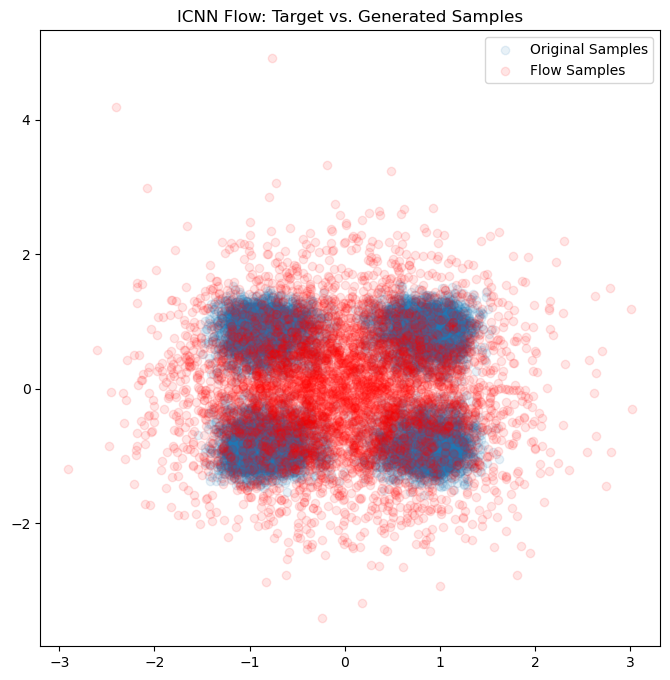

Saved icnn_generated_samples.png


In [9]:
# --- ICNN Flow Visualization ---
print("\n" + "=" * 80)
print("PART 1: ICNN FLOW VISUALIZATION")
print("=" * 80)

# 1. Get samples from the base distribution
S_base_tensor = base_dist.sample((5000,)).to(device)

# 2. Compute inverse map (sampling)
# We move the model to CPU for the L-BFGS solver if it's not on CUDA,
# as MPS can be slow with L-BFGS.
if optimal_device == "mps":
    model_icnn.to("cpu")
    S_base_tensor = S_base_tensor.to("cpu")

flow_samples = model_icnn.reverse(S_base_tensor, max_iter=10000, lr=1.0, tol=1e-8)
flow_samples = flow_samples.cpu().detach().numpy()

# Move model back to original device if needed
model_icnn.to(device)

# 3. Plot the results
plt.figure(figsize=(8, 8))
plt.scatter(X_target_icnn[:, 0], X_target_icnn[:, 1], alpha=0.1, label='Original Samples')
plt.scatter(flow_samples[:, 0], flow_samples[:, 1], alpha=0.1, label='Flow Samples', c='red')
plt.legend()
plt.title("ICNN Flow: Target vs. Generated Samples")
plt.savefig("icnn_generated_samples.png")
plt.show()
print("Saved icnn_generated_samples.png")


## Part 2: Tabak-Turner (RBF) Normalizing Flow
This section implements the Tabak-Turner algorithm using a linear combination (not composition) of Radial Basis Function (RBF) maps. The gradient of the log-likelihood is computed using JAX for automatic differentiation.

In [11]:
class NormalizingFlow_RBF:
    """
    Implements the Tabak-Turner normalizing flow algorithm using a
    linear combination of Radial Basis Function (RBF) maps.
    This version is corrected for JAX and NumPy 2.0 compatibility.
    """

    def __init__(self, n_p=50, epsilon=0.5):
        self.n_p = n_p
        self.epsilon = epsilon
        self.maps = []
        self.preconditioning = {}
        self.kl_history = []
        self.l2cost = np.nan
        # JAX requires 64-bit floats for stability in grads
        self.dtype = jnp.float64

    def _volume_n_ball(self, n):
        return np.pi**(n/2) / gamma(n/2 + 1)

    def _calculate_alpha(self, x0, n, m):
        omega_n = self._volume_n_ball(n)
        term = (omega_n**-1 * self.n_p / m)**(1/n)
        alpha = (2 * np.pi)**0.5 * term * np.exp(np.linalg.norm(x0)**2 / (2*n))
        return alpha

    def _radial_f(self, r, alpha):
        f_vals = np.zeros_like(r)
        nonzero_r = r != 0
        zero_r = ~nonzero_r
        r_scaled = r[nonzero_r] / alpha
        f_vals[nonzero_r] = erf(r_scaled) / r[nonzero_r]
        f_vals[zero_r] = 2.0 / (alpha * np.sqrt(np.pi))
        return f_vals

    def _radial_f_prime(self, r, alpha):
        f_prime_vals = np.zeros_like(r)
        nonzero_r = r != 0
        r_nz = r[nonzero_r]
        r_scaled = r_nz / alpha
        term1 = (2.0 / (alpha * np.sqrt(np.pi))) * np.exp(-r_scaled**2)
        term2 = erf(r_scaled) / r_nz
        f_prime_vals[nonzero_r] = (term1 - term2) / r_nz
        return f_prime_vals

    def compute_log_likelihood(self, J, z):
        """Computes the log-likelihood using JAX arrays."""
        m_py, n_py = z.shape # These are Python ints
        
        # --- FIX: Explicitly cast all Python scalars to JAX arrays ---
        n = jnp.array(n_py, dtype=self.dtype)
        std_dev = jnp.array(self.preconditioning['std'], dtype=self.dtype)
        const_0_5 = jnp.array(0.5, dtype=self.dtype)
        const_2pi = jnp.array(2 * jnp.pi, dtype=self.dtype)
        # --- End Fix ---

        term1 = jnp.log(jnp.abs(jnp.linalg.det(J))) - n * jnp.log(std_dev)
        term2 = -const_0_5 * jnp.sum(z**2, axis=1) - const_0_5 * n * jnp.log(const_2pi)
        return term1 + term2

    def compute_gradient(self, J, J_prime, z, f, diff):
        """
        Computes the gradient of the mean log-likelihood w.r.t. a step 't'.
        This function is designed to be traced by JAX.
        """
        # This is the function that will be differentiated by JAX
        def log_likelihood_mean(t, J, J_prime, z, f, diff):
            # Ensure t is also a JAX array of the correct type
            t = jnp.array(t, dtype=self.dtype) 
            
            J_new = J + (t * J_prime)
            z_new = z + t * (f[:, jnp.newaxis] * diff)
            return jnp.mean(self.compute_log_likelihood(J_new, z_new))
        
        # Partially apply the static arguments (the arrays)
        func = partial(log_likelihood_mean, J=J, J_prime=J_prime, z=z, f=f, diff=diff)
        
        # Compute the gradient with respect to the first argument (t) at t=0.0
        gradient = grad(func)
        return gradient(0.0) # Pass 0.0 as a standard float

    def compute_J_prime(self, m, n, diff, r, f, f_prime):
        J_prime = np.zeros((m, n, n))
        mask = r != 0
        J_prime[mask] = f[mask, None, None] * np.eye(n)
        scale = np.zeros(m)
        scale[mask] = f_prime[mask] / r[mask]
        outer_products = np.einsum('mi,mj->mij', diff, diff)
        J_prime += scale[:, np.newaxis, np.newaxis] * outer_products
        return J_prime

    def is_Convex(self, J, J_prime, beta, tol=1e-6):
        A = J + beta * J_prime
        eigenvalues = eigvals(A)
        min_eig = np.min(eigenvalues.real, axis=1)
        return np.all(min_eig >= tol)

    def compute_optimal_beta(self, J, J_prime, beta, num_iterations=8):
        if beta >= 0:
            return beta
        elif self.is_Convex(J, J_prime, beta):
            return beta
        else:
            beta_low = beta
            beta_high = 0
            for _ in range(num_iterations):
                beta_mid = (beta_low + beta_high) / 2
                if self.is_Convex(J, J_prime, beta_mid):
                    beta_high = beta_mid
                else:
                    beta_low = beta_mid
            return beta_high

    def fit(self, x, log_rho_exact=None, n_steps=1000):
        m, n = x.shape

        # 1. Preconditioning
        mean = np.mean(x, axis=0)
        z0 = x - mean
        std = np.sqrt(np.mean(np.sum(z0**2, axis=1)) / n)
        z0 /= std
        z = z0.copy()

        self.preconditioning = {'mean': mean, 'std': std}
        self.maps = []

        J = np.tile(np.eye(n)[np.newaxis, ...], (m, 1, 1))

        # Iterative map building
        for i in range(n_steps):
            if np.random.rand() > 0.5:
                idx = np.random.randint(m)
                x0 = z[idx]
            else:
                x0 = np.random.randn(n)

            alpha = self._calculate_alpha(x0, n, m)
            diff = z0 - x0
            r = np.linalg.norm(diff, axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)
            J_prime = self.compute_J_prime(m, n, diff, r, f, f_prime)

            # Convert all numpy arrays to JAX arrays before passing to JAX function
            # Ensure they match the 64-bit float type
            J_jnp = jnp.array(J, dtype=self.dtype)
            J_prime_jnp = jnp.array(J_prime, dtype=self.dtype)
            z_jnp = jnp.array(z, dtype=self.dtype)
            f_jnp = jnp.array(f, dtype=self.dtype)
            diff_jnp = jnp.array(diff, dtype=self.dtype)
            
            G = self.compute_gradient(J_jnp, J_prime_jnp, z_jnp, f_jnp, diff_jnp)
            G = np.array(G) # Convert gradient back to numpy

            v = self.epsilon / (np.sqrt(self.epsilon**2 + G**2))
            beta = v * G
            beta = self.compute_optimal_beta(J, J_prime, beta)

            J = J + beta * J_prime
            z = z + beta * f[:, np.newaxis] * diff

            self.maps.append({'x0': x0, 'alpha': alpha, 'beta': beta})

            if log_rho_exact is not None:
                # Also ensure JAX conversion here for KL calculation
                kl = np.mean(log_rho_exact(x) - np.array(self.compute_log_likelihood(jnp.array(J), jnp.array(z))))
                self.kl_history.append(kl)

            if (i+1) % (n_steps//10) == 0:
                if log_rho_exact is None:
                    print(f"Step {i+1}/{n_steps} completed")
                else:
                    print(f"Step {i+1}/{n_steps} completed, KL estimate: {self.kl_history[-1]:.4f}")
        
        print(f"Final convexity check: {self.is_Convex(J, np.zeros((m, n, n)), 0)}")


    def _transform(self, x_new):
        if x_new.ndim == 1:
            x_new = x_new.reshape(1, -1)
        m, n = x_new.shape

        z0 = (x_new - self.preconditioning['mean']) / self.preconditioning['std']
        z = z0.copy()

        J = np.tile(np.eye(n)[np.newaxis, ...], (m, 1, 1))

        for p in self.maps:
            x0, alpha, beta = p['x0'], p['alpha'], p['beta']
            diff = z0 - x0
            r = np.linalg.norm(diff, axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)
            J_prime = self.compute_J_prime(m, n, diff, r, f, f_prime)
            J = J + beta * J_prime
            z = z + beta * f[:, np.newaxis] * diff

        log_J_pre = -n * np.log(self.preconditioning['std'])
        abs_det_J = np.abs(np.linalg.det(J))
        log_J = log_J_pre + np.log(abs_det_J)

        return z, log_J

    def log_prob(self, x_new):
        if x_new.ndim == 1:
            x_new = x_new.reshape(1, -1)
        m, n = x_new.shape

        y, log_J = self._transform(x_new)
        log_prob_gaussian = -0.5 * np.sum(y**2, axis=1) - 0.5 * n * np.log(2 * np.pi)
        return log_prob_gaussian + log_J

In [12]:
# --- RBF Flow Data Generation and Training ---
print("\n" + "=" * 80)
print("PART 2: RBF FLOW TRAINING")
print("=" * 80)

def sample_exact_rbf(n_samples):
    """Data sampler for the RBF flow (cube-root of Gaussian)."""
    x1 = np.random.randn(n_samples)
    y1 = np.random.randn(n_samples)
    x = np.sign(x1) * (np.abs(x1)) ** (1 / 3)
    y = np.sign(y1) * (np.abs(y1)) ** (1 / 3)
    return np.stack([x, y], axis=1)

def log_rho_exact_rbf(xy):
    """Target log-density for the RBF flow."""
    x = xy[:, 0]
    y = xy[:, 1]
    n = 2
    # Avoid log(0) issues by adding a small epsilon
    epsilon = 1e-30
    log_rho = (-1/2)*(x**6 + y**6) + np.log(9) + np.log(x**2 + epsilon) + np.log(y**2 + epsilon) - (n/2)*np.log(2*np.pi)
    return log_rho


# 1. Sample data
x_rbf = sample_exact_rbf(10000)  # Sample from the true target density

# 2. Initialize and fit the model
flow_rbf = NormalizingFlow_RBF(n_p=500, epsilon=0.05)
n_steps = 600  # Number of steps to fit the model
flow_rbf.fit(x=x_rbf, log_rho_exact=log_rho_exact_rbf, n_steps=n_steps)


PART 2: RBF FLOW TRAINING


TypeError: asarray() got an unexpected keyword argument 'copy'

In [ ]:
# --- RBF Flow Visualization (KL Divergence) ---
print("\n" + "=" * 80)
print("PART 2: RBF FLOW VISUALIZATION (KL DIVERGENCE)")
print("=" * 80)

plt.figure(figsize=(8, 6))
plt.plot(flow_rbf.kl_history)
plt.title('RBF Flow: KL Divergence History')
plt.xlabel('Step')
plt.ylabel('KL Divergence')
plt.savefig("rbf_kl_history.png")
plt.show()
print("Saved rbf_kl_history.png")

In [ ]:
# --- RBF Flow Visualization (Density and L2 Cost) ---
print("\n" + "=" * 80)
print("PART 2: RBF FLOW VISUALIZATION (DENSITY & L2 COST)")
print("=" * 80)

# --- L2 Cost Calculation ---
grid_res_l2 = 100
x_range_l2 = np.linspace(-2, 2, grid_res_l2)
y_range_l2 = np.linspace(-2, 2, grid_res_l2)
xx_l2, yy_l2 = np.meshgrid(x_range_l2, y_range_l2)
grid_points_base = np.c_[xx_l2.ravel(), yy_l2.ravel()]  # Base grid (Gaussian)

# Target grid (Cube-root)
x_target_l2 = np.sign(x_range_l2) * (np.abs(x_range_l2)) ** (1 / 3)
y_target_l2 = np.sign(y_range_l2) * (np.abs(y_range_l2)) ** (1 / 3)
xx_target_l2, yy_target_l2 = np.meshgrid(x_target_l2, y_target_l2)
grid_points_target = np.c_[xx_target_l2.ravel(), yy_target_l2.ravel()]

# Apply the learned map T(grid_points_target) -> grid_points_estimate
grid_points_estimate, _ = flow_rbf._transform(grid_points_target)
l2cost = np.mean((grid_points_base - grid_points_estimate)**2)
print(f"The L2 cost (T(target) vs. base) is {l2cost}")

# --- Density Plotting ---
grid_res_density = 100
x_range_density = np.linspace(-2, 2, grid_res_density)
y_range_density = np.linspace(-2, 2, grid_res_density)
xx_density, yy_density = np.meshgrid(x_range_density, y_range_density)
grid_points_density = np.c_[xx_density.ravel(), yy_density.ravel()]

# Calculate the probability on the grid
log_p = flow_rbf.log_prob(grid_points_density)
p = np.exp(log_p).reshape(grid_res_density, grid_res_density)

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(18, 6))

# Plot 1: Original Data
ax1 = fig.add_subplot(1, 3, 1)
# Use a subset for clearer plotting
ax1.scatter(x_rbf[:1000, 0], x_rbf[:1000, 1], s=10, alpha=0.6, c='blue')
ax1.set_title("Original Data Sample (m=1000)")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)

# Plot 2: Learned Density
ax2 = fig.add_subplot(1, 3, 2)
contour = ax2.contourf(xx_density, yy_density, p, levels=15, cmap='viridis', norm=LogNorm())
ax2.contour(xx_density, yy_density, p, levels=15, colors='white', linewidths=0.5, alpha=0.7)
fig.colorbar(contour, ax=ax2, label="Probability Density")
ax2.set_title("Learned Density with RBF Flow")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)

# Plot 3: Mapped Grid (L2 Cost Viz)
ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(grid_points_estimate[:, 0], grid_points_estimate[:, 1], s=1, c='red', alpha=0.5)
ax3.set_title("Mapped Target Grid (should be Gaussian)")
ax3.set_xlabel("y1")
ax3.set_ylabel("y2")
ax3.set_aspect('equal', adjustable='box')
ax3.set_xlim(-3, 3)
ax3.set_ylim(-3, 3)


plt.tight_layout()
plt.savefig("rbf_density_and_l2.png")
plt.show()
print("Saved rbf_density_and_l2.png")